In [37]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import random
import re


# Grab the data
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')

## Step 1: Background and Problem description

For Module 4 in MSDS 5511 - Deep learning & AI, we have been asked to use recurrent neural networks to build a tweet classifier. A kaggle competition will be used to demonstrate knowledge of RNNs relating to natural language processing models (NLPs henceforth).

A dataset containing tweets with a binary incidator of whether or not the tweet is specifically relating to a natural disaster will be used to train a moedl.

## Step 2 - EDA

Exploratory data analysis will be performed on the data

In [38]:
print(train.head(5))

# We will only concern ourselves with the text

train = train.drop(['id','keyword','location'], axis=1)
test = test.drop(['id','keyword','location'], axis=1)
# Counts of binary target data
print(train.target.value_counts())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
0    4342
1    3271
Name: target, dtype: int64


We'd prefer to have balanced data. This will involve sampling an equal amount of 0s vs. 1s in the training set. Let's see what the trainnig set looks like first

In [39]:
NumTweets = 20

randomTweetIndex =  random.sample(list(train.index),NumTweets)

for i in randomTweetIndex:
    print(train.text[i])


Emergency units simulate a chemical explosion at NU - Evanston Now http://t.co/kfyEbhb3DI
Some guy whistled at me in the parking lot &amp; it did not help that the wind blew my skirt up getting in the car ??
Israeli forces raid home of alleged car attack suspect http://t.co/3GVUS8NPpy #palestine
LOOOOOOOOOOOOL who the bloody hell did that??  https://t.co/jRKGYl7Te5
70 years after : Hiroshima and Nagasaki - consequences of a nuclear detonation @ICRC http://t.co/BKh7Z6CWWl
this is the first time a tweet has blown up almost half a day later... RE https://t.co/1BUF0xM53d
Status: last seen buying body bags.
New Mad Max Screenshots Show Off a Lovely Dust Storm Combat Magnum Opus http://t.co/VRpmplcZCY
After all that time Riot should really make an official Satan Teemo skin http://t.co/TYtPBC4GWi
Sitting still in the #CityofMemphis traffic is like sitting in a war zone! They don't move for the Police.. They don't care
The @POTUS economy continues to collapse.
#SanDiego #News Sinkhole Disrupts

First, we can remove all redudant duplicate tweets

In [40]:
print('Before duplicates are removed: ',len(train))
train = train.drop_duplicates(subset='text', keep="first")
print('After Duplicates are removed: ',len(train))


Before duplicates are removed:  7613
After Duplicates are removed:  7503


A couple of things that immediately stand out are "@" direct mentions and 'http://' links.

Let's drop these two from the training group

In [41]:
# Note: functions below are derived from examples found at: https://docs.python.org/3/library/re.html


# Remove http links and @ mentions
def drop_links(line):
    link = re.compile(r'https?://\S+')
    return link.sub(r'', line)

def drop_mentions(line):
    tgt_twt = re.compile(r'@\S+')
    return tgt_twt.sub(r'', line)

def dropJunk_data(data):
    data['text'] = data['text'].apply(lambda x : drop_links(x))
    data['text'] = data['text'].apply(lambda x : drop_mentions(x))    
    return data

In [42]:
wiped_train = dropJunk_data(train)
wiped_test = dropJunk_data(test)

print('Training length :',len(wiped_train))
print(wiped_train['target'].value_counts())

Training length : 7503
0    4305
1    3198
Name: target, dtype: int64


The data is imbalanced. Downsample 0s to make it the same size as 1s

In [43]:
# Downsample 0s, concat 1s and zeros, shuffle

zeros = wiped_train[wiped_train['target']==0]
ones = wiped_train[wiped_train['target']==1]

zeros_sample = zeros.sample(n=len(ones))

wiped_train = pd.concat([zeros_sample,ones]).sample(frac=1, random_state=42).reset_index(drop=True)
wiped_train.head()
wiped_train['target'].value_counts()

0    3198
1    3198
Name: target, dtype: int64

In [44]:
# remove stop words
# NOTE: I have looked at examples found at: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
import nltk as nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def drop_stopwords(sentence):
    sen = sentence.split()
    wrd = [word for word in sen if word not in stopwords.words('english')]
    
    return ' '.join(wrd)

def processed_wo_stopwords(data):
    data['text'] = data['text'].apply(lambda x : drop_stopwords(x))   
    return data

train = processed_wo_stopwords(wiped_train)
test = processed_wo_stopwords(wiped_test)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jefferya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Samples
print(train.head(10))

                                                text  target
0  Tension In Bayelsa As Patience Jonathan Plans ...       1
1  Wreckage 'Conclusively Confirmed' From MH370: ...       1
2                                    heavy rain hail       1
3  #??? #?? #??? #??? MH370: Aircraft debris foun...       1
4                 disaster - can't say I'm surprised       0
5  Dutch crane collapses demolishes houses: Drama...       1
6                      Wrinkled face deluge decayed;       0
7  Guns protection.. That shit really used unless...       0
8  Legionnaires' Disease: What's Being Done Stop ...       1
9                                      There curfew.       0


Vectorize data:

I will create a corpus that contains train and test data by concatonating the two. I will then pass the corpus in to the vectorizer

In [46]:
# Note: This was a helpful notebook for understanding vectorization: 
#  https://www.kaggle.com/code/mattbast/rnn-and-nlp-detect-a-disaster-in-tweets/notebook#Encode-sentences

import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# Concat
corpus = pd.concat([train['text'],test['text']])
    
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

maxLen = max(len(c.split()) for c in corpus)
print('maximum length: ', maxLen)

maximum length:  28


In [47]:
trainFeatures = train.iloc[:,0]
trainLabels = train.iloc[:,1]
testFeatures = test.iloc[:,0]


trainToken = tokenizer.texts_to_sequences(trainFeatures)
testToken = tokenizer.texts_to_sequences(testFeatures)

# Pad with extra length follow tweet (if blank)
trainPadded = pad_sequences(trainToken, maxlen=maxLen, padding='post')
testPadded = pad_sequences(testToken, maxlen=maxLen, padding='post')

# Make an array of train labels for training the model
trainLabels = np.array(trainLabels)

## Step 3: Model Arch.

Let's build a model

LSTM is the way to go here, first because it is part of the assignment and secondly because we are working with sequence data. Keras has lots of lstm support. Bidirectional LSTM considers the sequence of training data in terms of front-to-back and back-to-front to find patterns. For my first model I will do 1 LSTM with 128 hidden layers. I need to first embed the data and then compress the LSTM output with a series of dense fully connected layers with tanh activations. Since the problem is a binary classification problem, I will use a single neuron output layer with sigmoid activation. The loss function will be Binary crossentropy.

In [48]:
# import tensorflow.keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Dropout, BatchNormalization
# from tensorflow.keras import optimizers


EmbeddedWords = len(tokenizer.word_index)+1
units = 144  # Just guessing 
hidden_units = 128

model_v1 = Sequential()
model_v1.add(Embedding(EmbeddedWords, units, input_length = maxLen))
model_v1.add(Bidirectional(LSTM(hidden_units)))
model_v1.add(Dense(256, activation='tanh'))
model_v1.add(Dense(128, activation='tanh'))
model_v1.add(Dense(64, activation='tanh'))
model_v1.add(Dense(1, activation='sigmoid'))

model_v1.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 144)           2632896   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               279552    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 3,019,457
Trainable params: 3,019,457
Non-trainable params: 0
____________________________________________

In [49]:

model_v1.compile( loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.00001),
    metrics=['accuracy', 'Precision', 'Recall'])


# Call back on test data as trigger
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)]


history_v1 = model_v1.fit(trainPadded, trainLabels, epochs=100, validation_split=0.25, callbacks = cb)


Epoch 1/100
150/150 [==============================] - 9s 42ms/step - loss: 0.6932 - accuracy: 0.5022 - precision: 0.4900 - recall: 0.1977 - val_loss: 0.6923 - val_accuracy: 0.5009 - val_precision: 0.8333 - val_recall: 0.0306

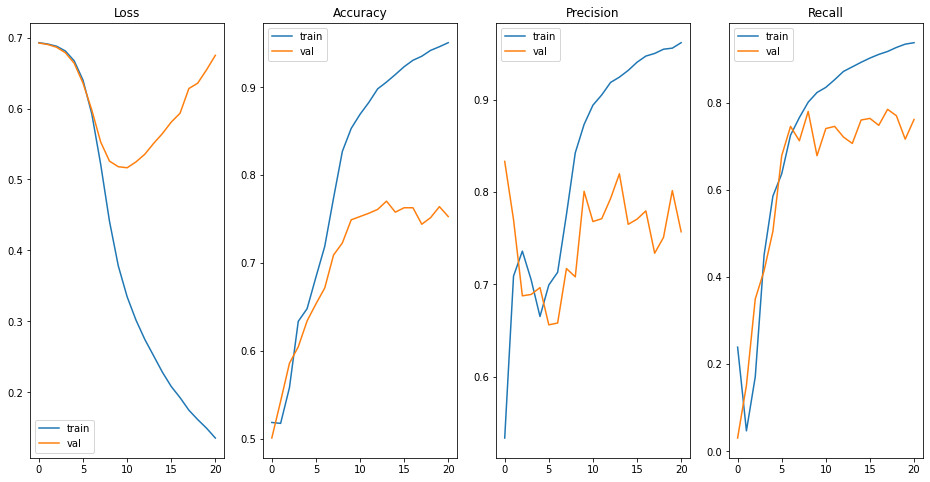

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,4, figsize=(16, 8))

axs[0].set_title('Loss')
axs[0].plot(history_v1.history['loss'], label='train')
axs[0].plot(history_v1.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history_v1.history['accuracy'], label='train')
axs[1].plot(history_v1.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history_v1.history['precision'], label='train')
axs[2].plot(history_v1.history['val_precision'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history_v1.history['recall'], label='train')
axs[3].plot(history_v1.history['val_recall'], label='val')
axs[3].legend()


Analysis:

Looking at the loss function vs. epoch, clearly the training is overfitting. I will subsequently tighten up the patience to 3 and change the stopping criteria to Accuracy because it seems like there is room for improvement on that metric.

I am going to experiement with dropout & Batchnorm as levers for improving test loss.


In [51]:

model_v2 = Sequential()
model_v2.add(Embedding(EmbeddedWords, units, input_length = maxLen))
model_v2.add(Bidirectional(LSTM(hidden_units)))
model_v2.add(Dropout(0.25))
model_v2.add(BatchNormalization())
model_v2.add(Dense(128, activation='tanh'))
model_v2.add(Dropout(0.25))
model_v2.add(BatchNormalization())
model_v2.add(Dense(64, activation='tanh'))
model_v2.add(Dropout(0.25))
model_v2.add(BatchNormalization())
model_v2.add(Dense(1, activation='sigmoid'))

model_v2.summary()

model_v2.compile( loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.00001),
    metrics=['accuracy', 'Precision', 'Recall'])

# Call back on test data as trigger
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
history_v2 = model_v2.fit(trainPadded, trainLabels,epochs=50,validation_split=0.2, callbacks = cb)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 28, 144)           2632896   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               279552    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)              

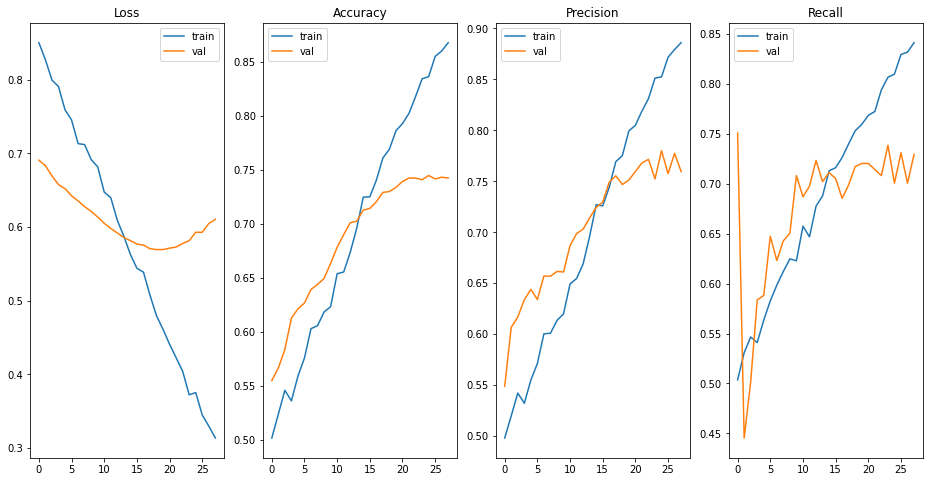

In [52]:
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].set_title('Loss')
axs[0].plot(history_v2.history['loss'], label='train')
axs[0].plot(history_v2.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history_v2.history['accuracy'], label='train')
axs[1].plot(history_v2.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history_v2.history['precision'], label='train')
axs[2].plot(history_v2.history['val_precision'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history_v2.history['recall'], label='train')
axs[3].plot(history_v2.history['val_recall'], label='val')
axs[3].legend()



Dropout and batch normalization really helped the model in terms of generalization. The loss function indicates overtraining, but the accuracy of the model is improving while loss is no longer improving. 

I will now swap the tanh function with sigmoid for the dense layers to see how this impacts the model.


In [53]:
model_v3 = Sequential()
model_v3.add(Embedding(EmbeddedWords, units, input_length = maxLen))
model_v3.add(Bidirectional(LSTM(hidden_units)))
model_v3.add(Dropout(0.25))
model_v3.add(BatchNormalization())
model_v3.add(Dense(128, activation='sigmoid'))
model_v3.add(Dropout(0.25))
model_v3.add(BatchNormalization())
model_v3.add(Dense(64, activation='sigmoid'))
model_v3.add(Dropout(0.25))
model_v3.add(BatchNormalization())
model_v3.add(Dense(1, activation='sigmoid'))

model_v3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 28, 144)           2632896   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               279552    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)              

In [54]:
model_v3.compile( loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.00001),
    metrics=['accuracy', 'Precision', 'Recall'])

history_v3 = model_v3.fit(trainPadded, trainLabels,epochs=50,validation_split=0.2, callbacks = cb)


Epoch 1/50
160/160 [==============================] - 11s 42ms/step - loss: 0.9163 - accuracy: 0.5000 - precision: 0.4991 - recall: 0.4882 - val_loss: 0.7079 - val_accuracy: 0.4859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

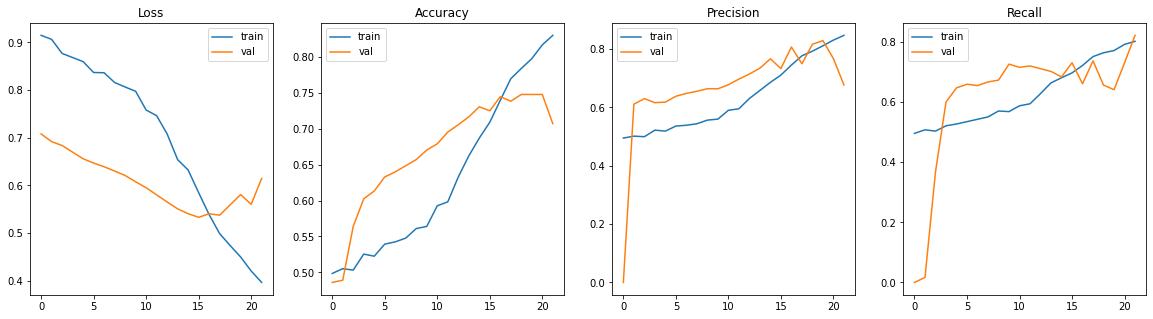

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(history_v3.history['loss'], label='train')
axs[0].plot(history_v3.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history_v3.history['accuracy'], label='train')
axs[1].plot(history_v3.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history_v3.history['precision'], label='train')
axs[2].plot(history_v3.history['val_precision'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history_v3.history['recall'], label='train')
axs[3].plot(history_v3.history['val_recall'], label='val')
axs[3].legend()

Switching to dense activations of Sigmoid vs. tanh showed marginal improvement to the accuracy performance in the test set.
For my last experiement I will add 1 more layer of Bidirectional LSTM to see if this increases performance.


In [59]:
model_v4 = Sequential()
model_v4.add(Embedding(EmbeddedWords, units, input_length = maxLen))
model_v4.add(Bidirectional(LSTM(hidden_units,return_sequences=True)))
model_v4.add(Dropout(0.25))
model_v4.add(Bidirectional(LSTM(hidden_units)))
model_v4.add(Dropout(0.25))
model_v4.add(BatchNormalization())
model_v4.add(Dense(128, activation='sigmoid'))
model_v4.add(Dropout(0.25))
model_v4.add(BatchNormalization())
model_v4.add(Dense(64, activation='sigmoid'))
model_v4.add(Dropout(0.25))
model_v4.add(BatchNormalization())
model_v4.add(Dense(1, activation='sigmoid'))

model_v4.summary()


model_v4.compile( loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.00001),
    metrics=['accuracy', 'Precision', 'Recall'])

history_v4 = model_v4.fit(trainPadded, trainLabels,epochs=50,validation_split=0.2, callbacks = cb)


axs[0].set_title('Loss')
axs[0].plot(history_v4.history['loss'], label='train')
axs[0].plot(history_v4.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history_v4.history['accuracy'], label='train')
axs[1].plot(history_v4.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history_v4.history['precision'], label='train')
axs[2].plot(history_v4.history['val_precision'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history_v4.history['recall'], label='train')
axs[3].plot(history_v4.history['val_recall'], label='val')
axs[3].legend()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 144)           2632896   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 28, 256)           279552    
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 256)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 128)              

An additional LSTM layer is not improving from the model_v3 performance. This will be the model to use going forward.


## Step 4: Results and Analysis

Multiple models were used to predict tweet classification based on text data. A single Bidirectional LSTM with dense fully connected layers each containing a sigmoid activation and Dropout & batchnormalization had the best convergence on maximum accuracy. The best accuracy in test data for model_v3 was 75.16%. Different activations on the dense layers as well as adding an extra LSTM layer did not improve the model.


In [61]:
preds = model_v3.predict(testPadded)

len(preds)

predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
        
# submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
# submission
#
# submission['target']=predictions
#
#
# submission.to_csv("submission.csv", index=False)


# Conclusion

I have only looked at LSTM layers and dense fully connected layers. I have seen other architecture like CNN used in conjunction w/ LSTM layers, but I did not study this for the problem being investigated. Different vectorization methods may yield better results. Obviously, more input features such as location and time may greatly enhance the model performance. Based on this notebook, it seems clear that putting more LSTM layers in to the model does not improve performance.
